# Mall Customer Segmentation Data

## Objective
One of the key marketing campaign problems involves understanding customers to deliver an effective marketing strategy within business constraints of time and costs. Customer segmentation is a key process that resolves this by targeting specific customers based on common characteristics. In this notebook, the process of customer segmentation is delivered by unsupervised clustering processes on data sourced from [here](https://www.kaggle.com/vjchoudhary7/customer-segmentation-tutorial-in-python).

In [1]:
#Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

%matplotlib inline

In [2]:
#Import modelling libraries
from itertools import combinations

#K-Means Clustering
from sklearn.cluster import KMeans

#Agglomeration Clustering 
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch

#DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

#3D Plotting
from mpl_toolkits.mplot3d import axes3d

#Silhouette Score
from sklearn.metrics import silhouette_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.metrics import davies_bouldin_score

## Load Data

In [3]:
#Load data
def load_file(df): 
    """
    Reads csv file as a Pandas dataframe.
    
    Parameters
    ----------
    df: name of csv file 
    
    Returns 
    -------
    Dataframe of csv file
    
    ---
    """
    return pd.read_csv(df)

In [4]:
#Load and define data
data = load_file('Mall_Customers.csv')

## Clean Data 

In [5]:
#Check data is DataFrame
type(data)

pandas.core.frame.DataFrame

In [6]:
#Preview data
data.head()

,CustomerID,Gender,Age,Annual Income (k$),Spending Score (1-100)
0,1,Male,19,15,39
1,2,Male,21,15,81
2,3,Female,20,16,6
3,4,Female,23,16,77
4,5,Female,31,17,40


In [7]:
#Check shape of data
data.shape

(200, 5)

In [8]:
#Check data types and missing data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   CustomerID              200 non-null    int64 
 1   Gender                  200 non-null    object
 2   Age                     200 non-null    int64 
 3   Annual Income (k$)      200 non-null    int64 
 4   Spending Score (1-100)  200 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 7.9+ KB


Appears to show no missing data and appropriate data types.

In [9]:
#Confirm check of no missing values
data.isnull().sum()

CustomerID                0
Gender                    0
Age                       0
Annual Income (k$)        0
Spending Score (1-100)    0
dtype: int64

In [10]:
#Descriptive stats for integer and float variables 
#Only integer variables in data; no float variables in data
data.describe()

,CustomerID,Age,Annual Income (k$),Spending Score (1-100)
count,200.000000,200.000000,200.000000,200.000000
mean,100.500000,38.850000,60.560000,50.200000
std,57.879185,13.969007,26.264721,25.823522
min,1.000000,18.000000,15.000000,1.000000
25%,50.750000,28.750000,41.500000,34.750000
50%,100.500000,36.000000,61.500000,50.000000
75%,150.250000,49.000000,78.000000,73.000000
max,200.000000,70.000000,137.000000,99.000000


In [11]:
#Descriptive stats for object variables 
data.describe(include='object')

,Gender
count,200
unique,2
top,Female
freq,112


No indication of invalid data from both descriptive stats above. 

In [12]:
#Check if CustomerID has no duplicates
data['CustomerID'].is_unique

True

Returning 'True' indicates no duplicates in CustomerID. 

No missing data, duplicates nor invalid data in the dataset before proceeeding to Exploratory Data Analysis and Modelling.

Column titles were updated to simplify the later sections.

In [13]:
#Original column names
print(data.columns)

Index(['CustomerID', 'Gender', 'Age', 'Annual Income (k$)',
       'Spending Score (1-100)'],
      dtype='object')


In [14]:
#Updated column names
data.columns = ['CustomerID', 'Gender', 'Age', 'Income','Score']
print(data.columns)

Index(['CustomerID', 'Gender', 'Age', 'Income', 'Score'], dtype='object')


# Exploratory Data Analysis

In [15]:
#Define features as data without CustomerID 
#features is used for EDA
features = data.drop('CustomerID',axis=1)

In [16]:
features

,Gender,Age,Income,Score
0,Male,19,15,39
1,Male,21,15,81
2,Female,20,16,6
3,Female,23,16,77
4,Female,31,17,40
...,...,...,...,...
195,Female,35,120,79
196,Female,45,126,28
197,Male,32,126,74
198,Male,32,137,18


In [17]:
type(features)

pandas.core.frame.DataFrame

In [18]:
features['Gender'].value_counts()

Female    112
Male       88
Name: Gender, dtype: int64

In [19]:
features['Gender'].value_counts(sort=False)

Female    112
Male       88
Name: Gender, dtype: int64

<Figure size 3600x3600 with 0 Axes>

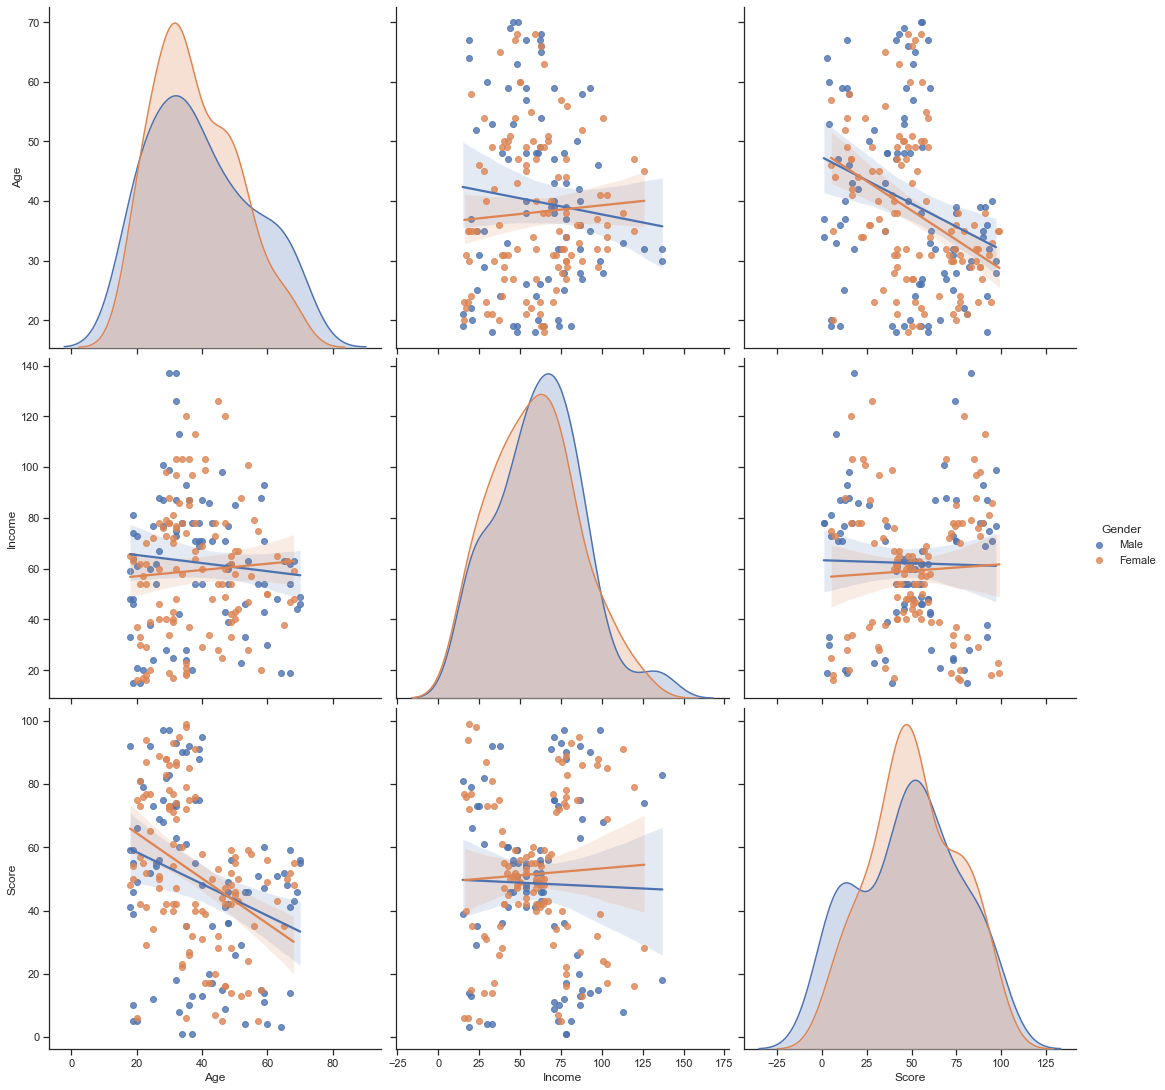

In [20]:
#Pairplots
plt.figure(figsize=(50,50))
sns.set(style="ticks")
sns.pairplot(features, hue='Gender',kind='reg',height = 5)
plt.savefig('Pairplots')
plt.show()

**Distributions** 
* Greater kurtosis of Females distributions for Age and Spending Score (1-100) than Males.
* Both Genders have similar Annual Income distributions.
* Both Genders have more spending scores roughly around 50.  
* Both Genders have two peaks in their distributions of Spending Scores: 
    * Males have one peak of low Spending Scores and another slightly above 50;
    * Females mostly have a Spending Score of 50 and another slight peak in the higher end of the Spending Scores. 

**Linear regressions and scatter plots** 
* No significant differences between Genders in terms of the relationships against each feature.
* No evident relationship between Age and Annual Income, but noticed that the younger and older ends of the age distribution have lower distribution and lower spread in Annual Income, while there is a greater spread and broader distribution of Annual Income for more middle-aged individuals. 
* The most significant correlation in terms of magnitude is the negative correlation between Spending Score and Age. 
* Possible clusters appear between Age and Spending Score, and for Spending Score and Annual Income. 

**Hypothesis of clustering**
* Potentially 5 clusters in the Annual Income and Spending Score scatter plots (see middle right and bottom middle plots).
* Between Age and Spending Scores, there could be 3 bins or clusters: (see bottom left plot)
    * 1. Aged between roughly 20 and below 50 with 60+ Spending Scores
    * 2. Majority across all ages between 20 to 60 in Spending Scores
    * 3. Spending Scores below 20. 

In [21]:
#Drop Gender variable 
features = features.drop('Gender',axis=1)
features.head()

,Age,Income,Score
0,19,15,39
1,21,15,81
2,20,16,6
3,23,16,77
4,31,17,40


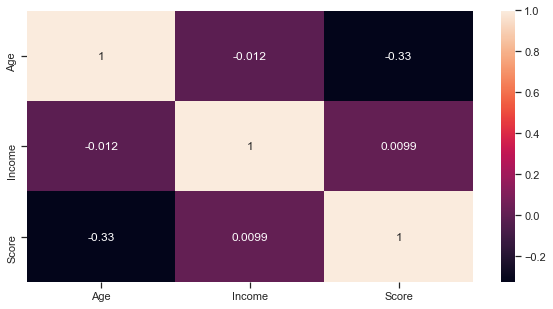

In [22]:
#Correlation heatmap
fig, axes = plt.subplots(figsize=(10, 5)) 
sns.heatmap(features.corr(),annot=True)
plt.savefig('corr_heatmap')
plt.show()

Only the negative correlation between age and spending score is significant, as shown earlier.

## Modelling

K-Means Clustering, Agglomerative Clustering and DBSCAN were models to cluster the individuals differently. Each model has its own approach to test parameters in selecting an appropriate model.  
* Inertia is calculated to find the elbow point, where the number of clusters is selected
* Dendrograms help with selecting the number of clusters and appropriate linkage method for Agglomerative Clustering
* The optimal epsilon value is  used for DBSCAN is based on finding the maximum curvature on a plot of the closest distances of each point to another point. 

Scatter plots and 3D plots (as 'Females' does not a play a significant factor in clustering) are shown to provide insights of the clustering results from each model. 

In [23]:
#Create all combinations of variables for scatter plots 
var_combos = combinations(features.columns,2)
var_combos = list(var_combos)

In [24]:
#All six combinations of scatter plots 
var_combos

[('Age', 'Income'), ('Age', 'Score'), ('Income', 'Score')]

### K-Means Clustering

In [25]:
#K-Means Clustering
labels = []
n_clusters = range(1,16)
inertia = []
features_k_means = features.copy()

for i in n_clusters:
    k_means = KMeans(init = "k-means++", n_clusters = i)
    k_means.fit(features_k_means)
    labels = k_means.labels_
    features_k_means[[i]]=pd.DataFrame(labels)
    inertia.append(k_means.inertia_)

C:\Users\61406\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


In [26]:
#Preview features_k_means
features_k_means.head()

,Age,Income,Score,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
0,19,15,39,0,1,2,1,0,5,5,5,3,1,6,10,12,8,8
1,21,15,81,0,0,2,1,2,2,3,2,0,4,8,3,4,0,4
2,20,16,6,0,1,2,3,0,5,5,5,3,6,7,10,5,8,9
3,23,16,77,0,0,2,1,2,2,3,2,0,4,8,3,4,0,4
4,31,17,40,0,1,2,3,0,5,5,5,3,1,6,10,12,8,8


In [27]:
#View inertia for each 'number of clusters'
inertia

[308812.7800000001,
 212840.16982097193,
 143371.5483196735,
 104394.32205350959,
 75394.68120881138,
 58373.2507568455,
 51155.3504031762,
 44372.94085227192,
 41015.76137742366,
 37364.48180556189,
 34461.76125472228,
 31960.477678483716,
 30229.072573952715,
 28224.647503046617,
 27008.550986732585]

In [28]:
#Create inertia1 as a dataframe copy of inertia
inertia1 = pd.DataFrame(inertia.copy())

In [29]:
#Create inertia2 as a dataframe copy of inertia1 that will be updated below
inertia2 = inertia1.copy()
inertia2.columns = ['inertia']

In [30]:
#Calculate differences in inertias
inertia2[['diff']]=inertia1.diff()

In [31]:
#Calculate percentage changes of inertias
inertia2[['pct_change']] = inertia1.pct_change()

In [32]:
#Set index as the number of clusters from 1 to 15
inertia2.index = range(1,16)

In [33]:
#View dataframe containing total inertia value, difference and percentage change by the number of clusters
inertia2

,inertia,diff,pct_change
1,308812.780000,NaN,NaN
2,212840.169821,-95972.610179,-0.310779
3,143371.548320,-69468.621501,-0.326389
4,104394.322054,-38977.226266,-0.271862
5,75394.681209,-28999.640845,-0.277789
6,58373.250757,-17021.430452,-0.225764
7,51155.350403,-7217.900354,-0.123651
8,44372.940852,-6782.409551,-0.132585
9,41015.761377,-3357.179475,-0.075658
10,37364.481806,-3651.279572,-0.089021


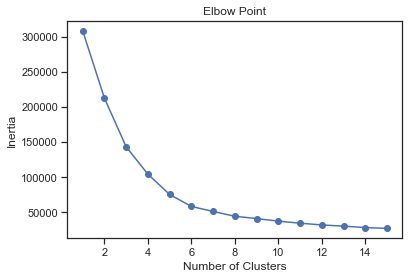

In [34]:
#Plot inertia for each numer of clusters
plt.plot(n_clusters,inertia,'bo-')
plt.ylabel('Inertia')
plt.xlabel('Number of Clusters')
plt.title('Elbow Point')
plt.savefig('kmeans_inertia')
plt.show()

Using the Elbow method, the elbow point appears to be 5 clusters, based on observing the highest negative percentage change in 'inertia2' and the plot above. The inertia decreases by default, but decreases insignificantly as the number of clusters increase after 5 clusters. 

The 5 clusters will be checked across various 2D scatter plots under each combination of variables, along with a 3D plot to combine the three key variables: Age, Score and Income. 

In [35]:
#Rename k=5 to Labels
features_k_means = features_k_means.rename(columns={5:'Labels'})

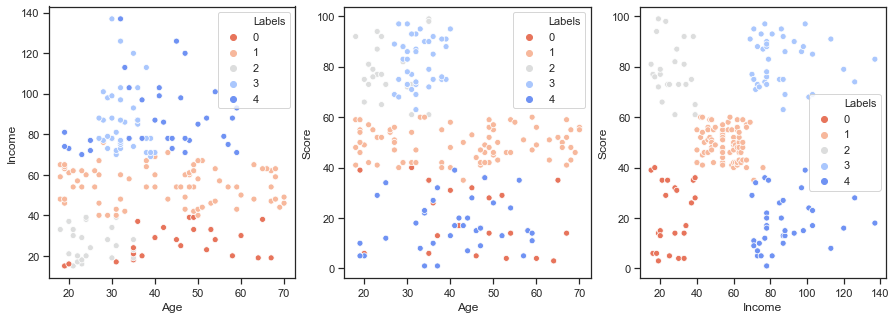

In [36]:
#Scatterplots for k = 5
fig, axes = plt.subplots(2,3, figsize=(15, 5)) 

for i in range(1,len(var_combos)+1):
    plt.subplot(1,3,i)
    sns.scatterplot(*var_combos[i-1],hue='Labels',data=features_k_means, palette=sns.color_palette('coolwarm_r',5))

plt.savefig('kmeans_scatter')
plt.show()

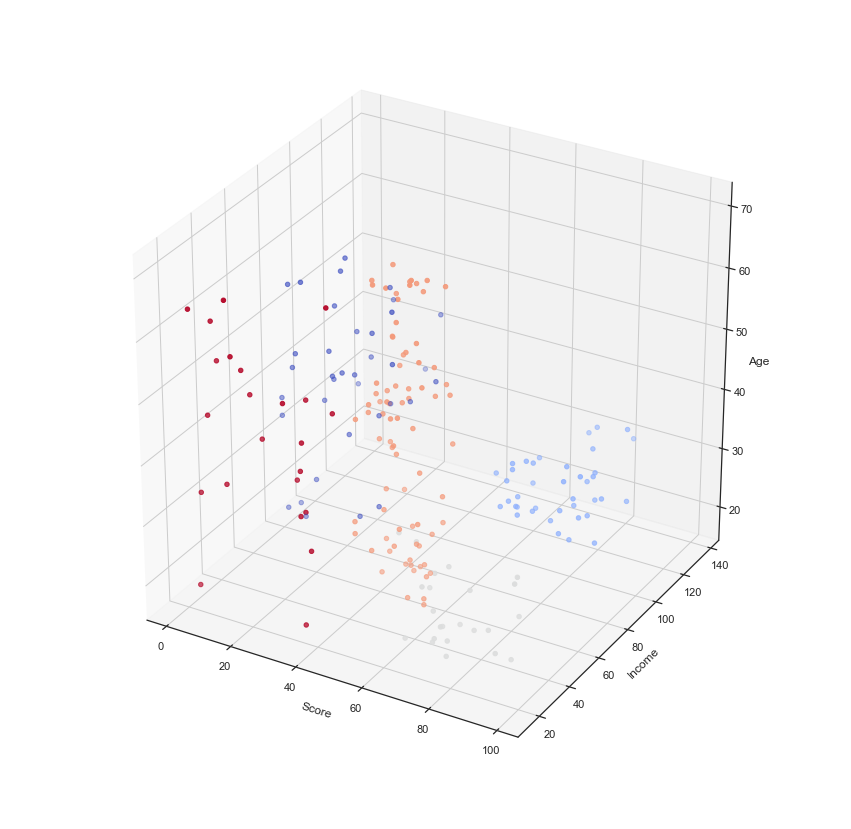

In [37]:
#K-Means 3D Plot
#%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

#Axis values
x = features_k_means['Score']
y = features_k_means['Income']
z = features_k_means['Age']

#Axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Income')
ax.set_zlabel('Age')

#3D Plot
ax.scatter(x,y,z, c=features_k_means['Labels'], cmap='coolwarm_r')

#To avoid z-label get cut off
ax.dist = 11

#set size of plot
fig.set_size_inches(15, 15)

plt.savefig('kmeans_3D')
plt.show()

**K-Means Clustering shows 5 clusters:**
* Red: High Income and Spending Score, and under 40 years of age
* Orange: High Income and low Spending Score 
* Light Blue: medium Income and Spending Score 
* Blue: Low Income and high Spending Score, and under 40 years of age
* Grey: Low Income and Spending Score.

### Agglomeration Clustering

Dendrograms were built for each of the four linkage methods to be considered below. 

In [38]:
#Linkages to test
linkage = ['ward', 'complete', 'average', 'single']

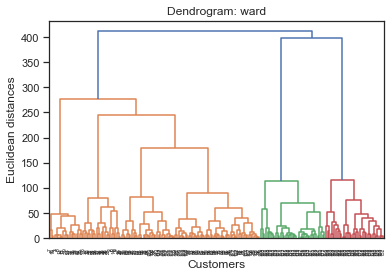

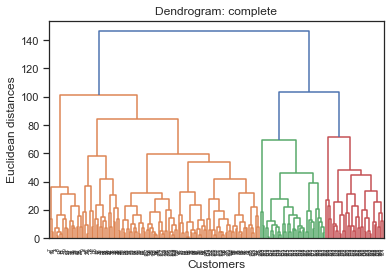

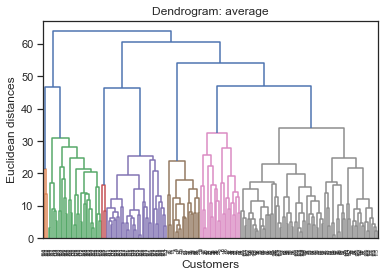

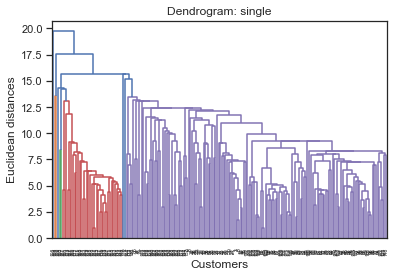

In [39]:
#Scatterplots

for i in linkage:
    dendrogram = sch.dendrogram(sch.linkage(features, method=i))
    plt.title('Dendrogram: '+i)
    plt.xlabel('Customers')
    plt.ylabel('Euclidean distances')
    plt.savefig('Dendrogram_'+i)
    plt.show()

The longest vertical distance without any horizontal line passing would help determine the number of selected clusters. From the above dendrograms, this is the most clear using the 'ward' linkage method on the right-hand side. 

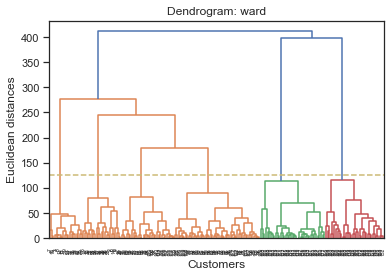

In [40]:
#Dendrogram cut-off based on the longest vertical distance without any horizontal line passing
dendrogram = sch.dendrogram(sch.linkage(features, method='ward'))
plt.title('Dendrogram: ward')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')

plt.axhline(y=125, color='y', linestyle='--')

plt.savefig('Dendrogram__Ward')
plt.show()

By observing for distances below 125 roughly, there are 6 clusters that are shown with 6 vertical lines below the distance of roughly 125. 

In [41]:
#Agglomerative Clustering
labels = []

#Agglomerative Clustering: 6 clusters, euclidean distance and ward linkage method
agg = AgglomerativeClustering(n_clusters=6, affinity='euclidean', linkage='ward')
agg.fit(features)
labels.append(agg.labels_)
labels = pd.DataFrame(agg.labels_)

In [42]:
#Add labels to dataframe for plotting
features_agg = features.copy()
features_agg[['Labels']] = labels
features_agg

,Age,Income,Score,Labels
0,19,15,39,4
1,21,15,81,3
2,20,16,6,4
3,23,16,77,3
4,31,17,40,4
...,...,...,...,...
195,35,120,79,2
196,45,126,28,0
197,32,126,74,2
198,32,137,18,0


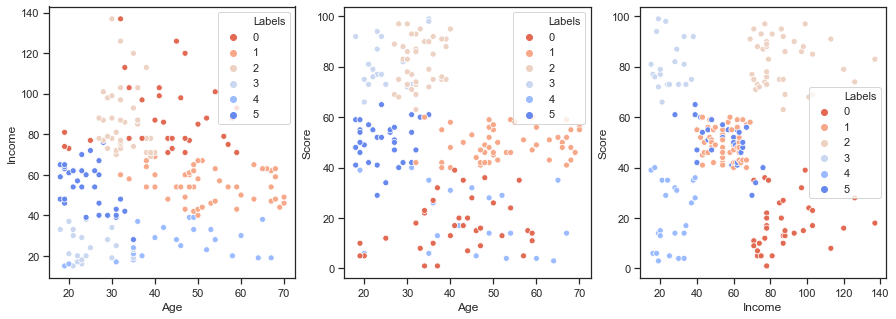

In [43]:
#Scatterplots for k = 6
fig, axes = plt.subplots(2,3, figsize=(15, 5)) 

for i in range(1,len(var_combos)+1):
    plt.subplot(1,3,i)
    sns.scatterplot(*var_combos[i-1],hue='Labels',data=features_agg, palette=sns.color_palette('coolwarm_r',6))
plt.savefig('agg_scatter')
plt.show()

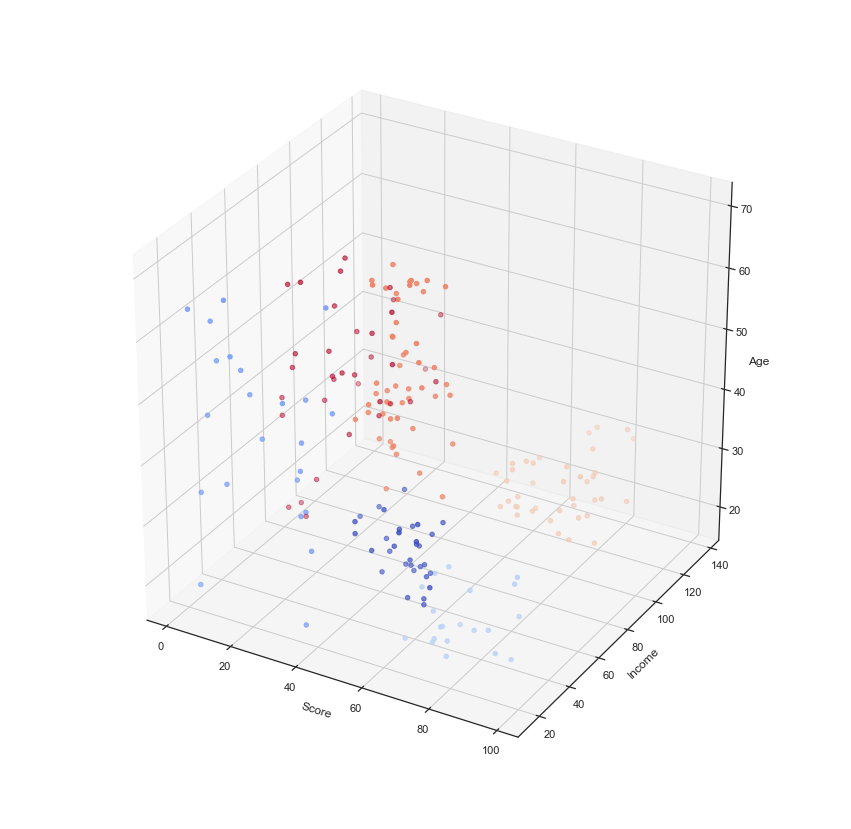

In [44]:
#Agglomerative Clustering 3D Plot
#%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

#Axis values
x = features_agg['Score']
y = features_agg['Income']
z = features_agg['Age']

#Axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Income')
ax.set_zlabel('Age')

#3D Plot
ax.scatter(x,y,z, c=features_agg['Labels'], cmap='coolwarm_r')

#To avoid z-label get cut off
ax.dist = 11

#set size of plot
fig.set_size_inches(15, 15)

plt.savefig('agg_3D')
plt.show()

**Agglomerative Clustering shows 6 clusters:**

* Red: High Income, low Spending Score 
* Light Orange: High Income and Spending Score, and under 40 years of Age
* Orange: Medium Income and Spending Score, and over 30 years of Age
* Dark Blue: Medium Income and Spending Score, and under 30 years of Age
* Blue: Low Income and Spending Score
* Light Blue: Low Income, high Spending Score and under 30 years of Age.

### DBSCAN

In [45]:
#Use NearestNeighbors to find each point's closest distance from another point. 
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(features)
distances, indices = nbrs.kneighbors(features)

In [46]:
distances = np.sort(distances, axis=0)
distances = distances[:,1]

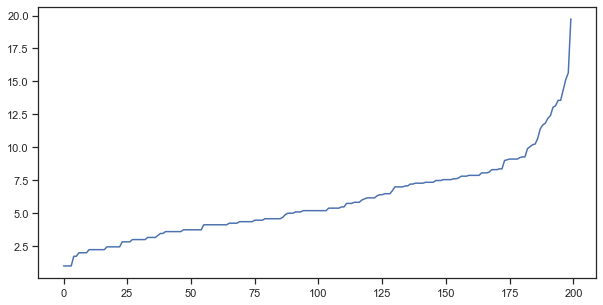

In [47]:
#Plot to find the optimal epsilon for DBSCAN
fig, axes = plt.subplots(figsize=(10, 5)) 
plt.plot(distances)

The optimal value for epsilon is be found at the point of maximum curvature.
From the above, the epsilon is 10.

In [48]:
#DBSCAN 
labels = []
features_dbscan = features.copy()

#Point of maximum curvature is when distance (eps) = 10
#Note: min_samples parameter is set as the default of 5 
dbscan = DBSCAN(eps = 10).fit(features_dbscan)
labels = dbscan.labels_
features_dbscan[['Labels']]=pd.DataFrame(labels)

In [49]:
features_dbscan

,Age,Income,Score,Labels
0,19,15,39,-1
1,21,15,81,0
2,20,16,6,-1
3,23,16,77,0
4,31,17,40,-1
...,...,...,...,...
195,35,120,79,-1
196,45,126,28,-1
197,32,126,74,-1
198,32,137,18,-1


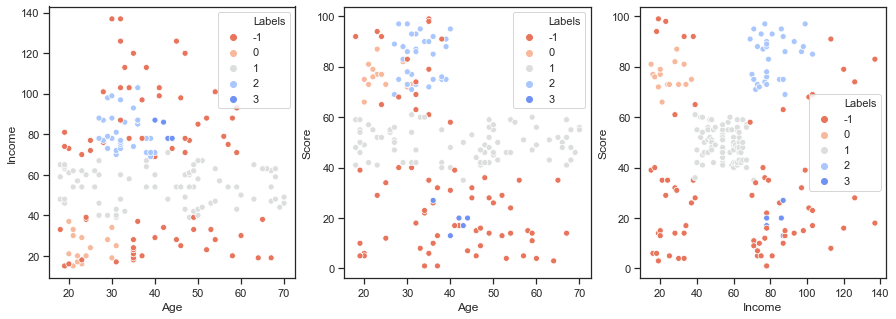

In [50]:
#Scatterplots for eps = 10
fig, axes = plt.subplots(2,3, figsize=(15, 5)) 

for i in range(1,len(var_combos)+1):
    plt.subplot(1,3,i)
    sns.scatterplot(*var_combos[i-1],hue='Labels',data=features_dbscan, 
                    palette=sns.color_palette('coolwarm_r', len(set(features_dbscan['Labels']))))
    
plt.savefig('dbscan_scatter')
plt.show()

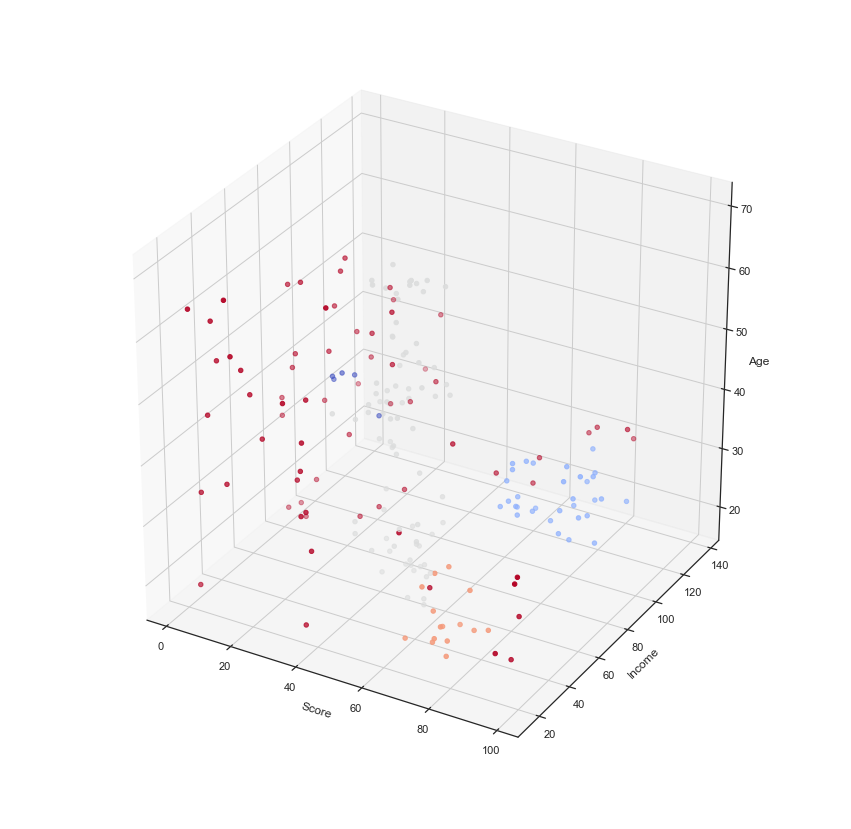

In [51]:
#DBSCAN 3D Plot
#%matplotlib notebook

fig = plt.figure()
ax = fig.add_subplot(1,1,1, projection='3d')

#Axis values
x = features_dbscan['Score']
y = features_dbscan['Income']
z = features_dbscan['Age']

#Axis labels
ax.set_xlabel('Score')
ax.set_ylabel('Income')
ax.set_zlabel('Age')

#3D Plot
ax.scatter(x,y,z, c=features_dbscan['Labels'], cmap='coolwarm_r')

#To avoid z-label get cut off
ax.dist = 11

#set size of plot
fig.set_size_inches(15, 15)

plt.savefig('dbscan_3D')
plt.show()

**DCSCAN shows 4 clusters:**

* Orange: Low Income, high Spending Score under 30 years of Age
* Light Blue: slightly high Income with a high Spending Score, and under 40 years of Age
* Blue: Low Spending Score, slightly higher Income and around 40 years of age
* Grey: Slightly lower Income and moderate Spending Score 
* Red: Outliers.

## Evaluation

In [52]:
#Evaluating unsupervised clustering (optimal) models 

#1. K-Means, 5 clusters
k_means = KMeans(init = "k-means++", n_clusters = 5)

#2. Agglomerative Clustering, 6 clusters
agg

#3. DBSCAN
dbscan

#Models
models = [k_means, agg, dbscan]

#Store scores
sc = []
chi = []
dbi = [] 

#Evaluate unsupervised clustering with Silhouette Score
for model in models: 
    model.fit(features)
    labels = model.labels_
    sc.append(silhouette_score(features, labels))
    chi.append(calinski_harabasz_score(features, labels))
    dbi.append(davies_bouldin_score(features, labels))

#Store metric values
metric_names = ['Silhouette Coefficient', 'Calinski-Harabasz Index', 'Davies-Bouldin Index']
metrics = [sc, chi, dbi]

In [53]:
#Performance metrics dataframe
perf_eval = pd.DataFrame(metrics).transpose()
perf_eval.columns = metric_names
perf_eval.index = models 

display(perf_eval)

,Silhouette Coefficient,Calinski-Harabasz Index,Davies-Bouldin Index
KMeans(n_clusters=5),0.444286,151.043860,0.821878
AgglomerativeClustering(n_clusters=6),0.443089,159.455643,0.768478
DBSCAN(eps=10),0.152126,30.507714,2.029689


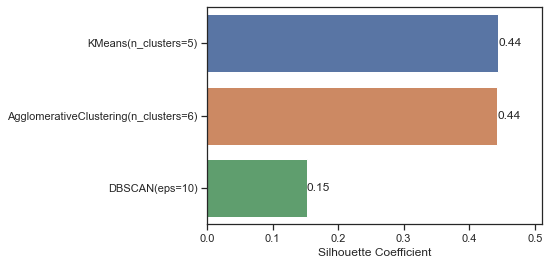

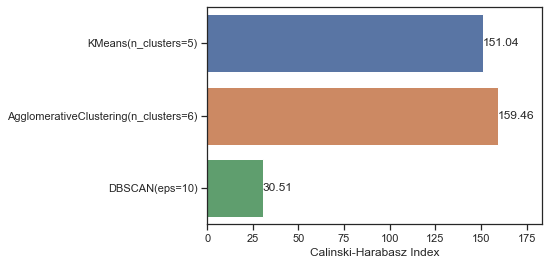

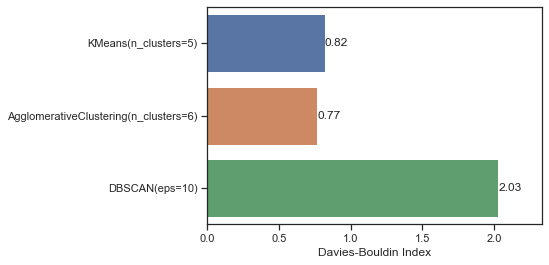

In [54]:
#Horizontal plots of each performance metric 
for metric in metric_names:
    #plt.title(metric)
    ax=sns.barplot(x=perf_eval[metric], y=models, orient = 'h')
    ax.set_xlim(0,max(perf_eval[metric])*1.15)
    for p in ax.patches:
        width = p.get_width()    # get bar length
        ax.text(width,       # set the text at 1 unit right of the bar
                p.get_y() + p.get_height() / 2, # get Y coordinate + X coordinate / 2
                '{:1.2f}'.format(width), # set variable to display, 3 decimals
                ha = 'left',   # horizontal alignment
                va = 'center')  # vertical alignment

    plt.savefig(metric)    
    plt.show()

## Deploying Solution

**Agglomerative Clustering** results show that is the deployable solution producing the most clear-cut clusters. 

Despite K-Means producing a fractionally higher Silhoutte Coefficient than Agglomerative Clustering, both the Calinski-Harabasz Index and Davies-Bouldin Index distinctly favour Agglomerative Clustering. 

Note that DBSCAN distinguishes from these techniques with the ability to show outliers. It also does not generally score well with these metrics, which is a common drawback of these metrics. 

To deliver an effective marketing campaign, different approaches could be catered to each of the following customer segmentations, split by the three domains. 

* Two high Income groups of customers: 
    * i) one with low Spending Scores 
    * ii) another with high Spending Scores and under 40 years of Age
    
    
* Two medium Income and Spending Score customer groups: 
    * iii) one over 30 years of Age
    * iv) another under 30 years of Age
    
    
* Two low Income groups of customers: 
    * v) one with low Spending Scores
    * vi) Another with high Spending Scores and under 30 years of Age.

# Appendix

Markdown tables for reference.

In [55]:
print(features.describe().to_markdown())

|       |     Age |   Income |    Score |
|:------|--------:|---------:|---------:|
| count | 200     | 200      | 200      |
| mean  |  38.85  |  60.56   |  50.2    |
| std   |  13.969 |  26.2647 |  25.8235 |
| min   |  18     |  15      |   1      |
| 25%   |  28.75  |  41.5    |  34.75   |
| 50%   |  36     |  61.5    |  50      |
| 75%   |  49     |  78      |  73      |
| max   |  70     | 137      |  99      |


In [56]:
print(perf_eval.to_markdown())

|                                       |   Silhouette Coefficient |   Calinski-Harabasz Index |   Davies-Bouldin Index |
|:--------------------------------------|-------------------------:|--------------------------:|-----------------------:|
| KMeans(n_clusters=5)                  |                 0.444286 |                  151.044  |               0.821878 |
| AgglomerativeClustering(n_clusters=6) |                 0.443089 |                  159.456  |               0.768478 |
| DBSCAN(eps=10)                        |                 0.152126 |                   30.5077 |               2.02969  |
